## Test cross-correlations on GCI AK DAS data

originally by Ethan Williams 2023-03-18

modified by Marine Denolle (1/3/2024)

Import modules

In [48]:
%matplotlib inline
import os
import sys
sys.path.append('../src/')
import h5py
import numpy as np
import matplotlib.pyplot as plt
import psf_module as psf # our PSF module

# from scipy.signal import detrend, filtfilt, butter

# from obspy import UTCDateTime

Make the list of files

In [50]:
# data files
dir0='/Users/marinedenolle/homer'
fdir = dir0+'/data_kkfln/'
flist = np.array(os.listdir(fdir))
ftime = np.array([psf.get_tstamp(fname) for fname in flist])
index = np.argsort(np.array(ftime)-ftime[0])
flist = flist[index]
ftime = ftime[index]


Prepare cross correlation job

In [ ]:

# dictionary for the Xcorr job.
recmin = 1000 # minimal source
recmax = 8000 # receiver channel
fmin = 0.1 # minimal frequency
fmax = 10. # maximal frequency
whiten = True # whiten the data 
onebit = True # one bit normalization
srcx = 1000 # channel source location    
nns = 200 # number of time samples for the xcorr.

pdict = {'srcx': srcx, 'recmin': recmin, 'recmax': recmax, 'nns': nns, \
        'fmin': fmin, 'fmax': fmax, 'whiten': whiten, 'onebit': onebit}


In [40]:
xc = psf.simple_xc(fdir,flist)
xc.compute_xc(pdict)


/Users/marinedenolle/homer/data/ decimator2_2024-01-01_22.50.56_UTC.h5
File 1/2
File 2/2
2 7


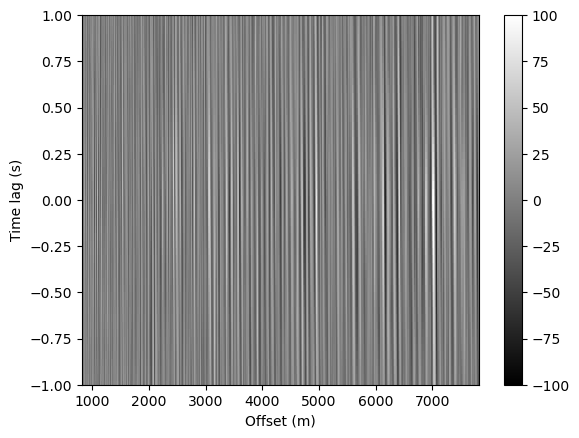

In [42]:
plt.figure(); v = 100
plt.pcolormesh(xc.offset,xc.lags,xc.trxc.T,vmin=-v,vmax=v,cmap='gray')
plt.xlim([min(xc.offset),max(xc.offset)])
plt.ylim([-1,1])
plt.xlabel('Offset (m)')
plt.ylabel('Time lag (s)')
plt.colorbar()

In [44]:
# idx = np.logical_and(xc.offset>=0,xc.offset<=120)
# shot = xc.trxc[idx,:]
# off = xc.offset[idx]
# lag = xc.lags
# shotf = np.fft.rfft(shot,axis=1)

# vs = np.linspace(100,800,50)
# nv = len(vs)
# ns = len(lag)
# nx = len(off)
# frq = np.fft.rfftfreq(ns,d=1./fs)
# disp = np.zeros((nv,ns//2+1))
# for iv in range(nv):
#     shift = shotf.copy()
#     for ix in range(nx):
#         shift[ix,:] *= np.exp(2j*np.pi*frq*off[ix]/vs[iv])
#     disp[iv,:] = abs(np.mean(np.real(shift),axis=0))


In [45]:
# plt.figure()
# plt.pcolormesh(frq,vs,disp)
# plt.xlim([0,20])
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Phase velocity (m/s)')
# plt.colorbar()

# # can also normalize
# disp /= np.tile(np.max(disp,axis=0),(nv,1))

# plt.figure()
# plt.pcolormesh(frq,vs,disp)
# plt.xlim([0,20])
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Phase velocity (m/s)')
# plt.colorbar()